In [19]:
import os, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import os 
import pathlib 
import random
%matplotlib inline
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import time
import warnings
warnings.filterwarnings("ignore")
print(time.strftime("%Y-%m-%d %H:%M:%S"))

2022-07-17 14:03:37


In [2]:
img_needed_size = (224, 224)

In [4]:
#W:\Home\hahmad\public\temp _project\crop classification\archive\kag2
categories=os.listdir('W:/Home/hahmad/public/temp _project/crop classification/archive/kag2')
print(categories)

['jute', 'maize', 'rice', 'sugarcane', 'wheat']


In [6]:
# load data 
kag2_ds=keras.preprocessing.image_dataset_from_directory(
    'W:/Home/hahmad/public/temp _project/crop classification/archive/kag2',
    labels='inferred',
    image_size=img_needed_size,
    batch_size=32,
    label_mode='categorical',
    shuffle=True)
print(kag2_ds)

Found 804 files belonging to 5 classes.
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


In [7]:
crop_image_ds=keras.preprocessing.image_dataset_from_directory(
    'W:/Home/hahmad/public/temp _project/crop classification/archive/crop_images',
    labels='inferred',
    image_size=img_needed_size,
    batch_size=32,
    label_mode='categorical',
    shuffle=True)
print(crop_image_ds)

Found 201 files belonging to 5 classes.
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


In [11]:
# prepare model backbone and final model
backbone_model=keras.applications.MobileNetV2(
    input_shape=(*img_needed_size, 3),
    include_top=False,
    weights='imagenet')
print(backbone_model)

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
# freezebase model's weights
backbone_model.trainable=False

In [13]:
final_model=keras.Sequential([
    backbone_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(len(categories), activation='softmax')
])

In [15]:
# compile model
final_model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4014144   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 6,274,821
Trainable params: 4,016,837
Non-trainable params: 2,257,984
______________________________________

In [16]:
#Test the model on datasets, see initial results
final_model.evaluate(kag2_ds)
final_model.evaluate(crop_image_ds)

7/7 [==============================] - 3s 419ms/step - loss: 1.7423 - categorical_accuracy: 0.1891


[1.742316722869873, 0.1890547275543213]

In [18]:
# fit model
final_model.fit(kag2_ds, epochs=10,batch_size=32,shuffle=True)


Epoch 1/10
26/26 [==============================] - 17s 461ms/step - loss: 1.8419 - categorical_accuracy: 0.2351
Epoch 2/10
26/26 [==============================] - 12s 448ms/step - loss: 1.4976 - categorical_accuracy: 0.2836
Epoch 3/10
26/26 [==============================] - 12s 462ms/step - loss: 1.3782 - categorical_accuracy: 0.4428
Epoch 4/10
26/26 [==============================] - 12s 448ms/step - loss: 1.4193 - categorical_accuracy: 0.3943
Epoch 5/10
26/26 [==============================] - 12s 452ms/step - loss: 1.3044 - categorical_accuracy: 0.5124
Epoch 6/10
26/26 [==============================] - 13s 473ms/step - loss: 1.3218 - categorical_accuracy: 0.4639
Epoch 7/10
26/26 [==============================] - 12s 456ms/step - loss: 1.2656 - categorical_accuracy: 0.4925
Epoch 8/10
26/26 [==============================] - 12s 461ms/step - loss: 1.3178 - categorical_accuracy: 0.4465
Epoch 9/10
26/26 [==============================] - 12s 450ms/step - loss: 1.2759 - categorical_

In [19]:
#Test the model on datasets, see trained results
final_model.evaluate(kag2_ds)   
final_model.evaluate(crop_image_ds)

7/7 [==============================] - 3s 415ms/step - loss: 1.3137 - categorical_accuracy: 0.4179


[1.3136698007583618, 0.41791045665740967]

Prediction: %0.56 wheat
Target: %1.00 rice


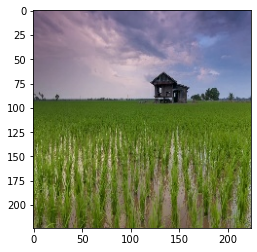

Prediction: %0.31 jute
Target: %1.00 maize


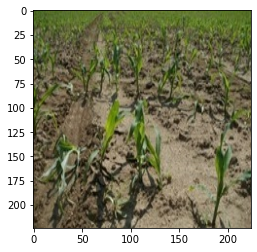

Prediction: %0.56 wheat
Target: %1.00 wheat


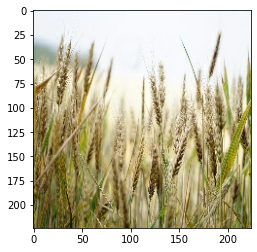

Prediction: %0.43 jute
Target: %1.00 jute


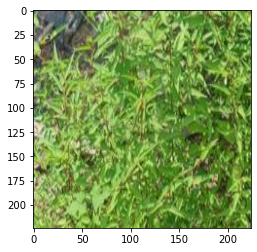

Prediction: %0.33 jute
Target: %1.00 maize


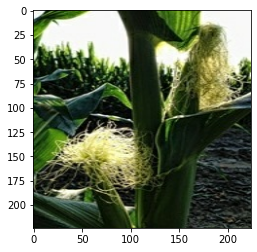

Prediction: %0.73 sugarcane
Target: %1.00 maize


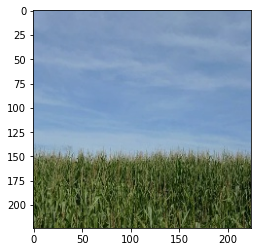

Prediction: %0.31 jute
Target: %1.00 jute


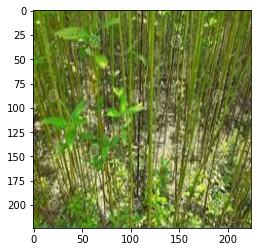

Prediction: %0.30 sugarcane
Target: %1.00 wheat


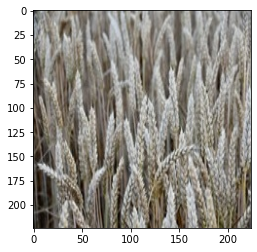

Prediction: %0.30 sugarcane
Target: %1.00 rice


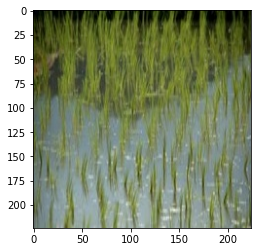

Prediction: %0.30 sugarcane
Target: %1.00 sugarcane


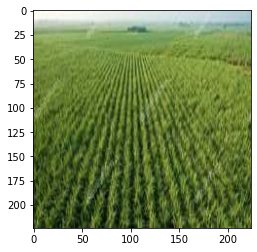

In [24]:
# def function to plot images
def test_model(data,max_sample=10):
    for X,y in crop_image_ds:
        for s in range(0,min(X.shape[0],max_sample)):
            X_sample=X[s:s+1]
            y_sample=y[s:s+1]
            # predict
            y_pred=final_model.predict(X_sample)[0]
            # print prediction
            print("Prediction: %{0:.2f} {1:s}\nTarget: %{2:.2f} {3:s}".format(np.max(y_pred),categories[np.argmax(y_pred)],np.max(y_sample),categories[np.argmax(y_sample)]))
            # plot image
            plt.imshow(np.array(X_sample[0],dtype=np.int32))
            plt.show()
        break
test_model(crop_image_ds)

In [34]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import cv2
import re
import random
random.seed(0)
np.random.seed(0)

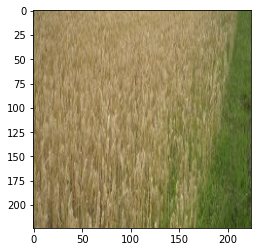

In [29]:
## wheat
wheat=plt.imread('W:/Home/hahmad/public/temp _project/crop classification/archive/kag2/wheat/wheat0001a.jpeg')
plt.imshow(wheat)

In [35]:
#converting to traing and test data
jutepath = "W:/Home/hahmad/public/temp _project/crop classification/archive//kag2/jute"
maizepath = "W:/Home/hahmad/public/temp _project/crop classification/archive/kag2/maize"
ricepath = "W:/Home/hahmad/public/temp _project/crop classification/archive/kag2/rice"
sugarcanepath = "W:/Home/hahmad/public/temp _project/crop classification/archive/kag2/sugarcane"
wheatpath = "W:/Home/hahmad/public/temp _project/crop classification/archive/kag2/wheat"

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)

X= []
for fname in jutefilename:
    X.append([os.path.join(jutepath,fname),0])
for fname in maizefilename: 
    X.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X.append([os.path.join(sugarcanepath,fname),3])
for fname in wheatfilename:
    X.append([os.path.join(wheatpath,fname),4])
X=pd.DataFrame(X,columns=['path','labels'])
X.head(3)

,path,labels
0,W:/Home/hahmad/public/temp _project/crop class...,0
1,W:/Home/hahmad/public/temp _project/crop class...,0
2,W:/Home/hahmad/public/temp _project/crop class...,0


In [36]:
ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,ohlabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

In [37]:
train,test = train_test_split(new_X,test_size=0.2,random_state=32,shuffle = True)

In [38]:
X_train = train['path'].values
y_train = train.drop(['path'],axis=1).values
X_test = test['path'].values
y_test = test.drop(['path'],axis=1).values

In [39]:
def deep_pipeline(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)       
    return flat

In [40]:
dx_train = deep_pipeline(X_train)
dx_test = deep_pipeline(X_test)

In [44]:
# model training with vgg19
keras.backend.clear_session()
vgg = keras.applications.vgg19.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5005      
Total params: 22,544,389
Trainable params: 2,520,005
Non-trainable params: 20,024,384
_________________________________________________________________


In [45]:
hist = vggmodel.fit(dx_train,y_train,epochs=50,validation_split=0.3,batch_size=16)

Epoch 1/50
29/29 [==============================] - 485s 17s/step - loss: 2.8692 - accuracy: 0.2622 - val_loss: 1.4033 - val_accuracy: 0.3990
Epoch 2/50
29/29 [==============================] - 482s 17s/step - loss: 1.2296 - accuracy: 0.5000 - val_loss: 1.0536 - val_accuracy: 0.5233
Epoch 3/50
29/29 [==============================] - 481s 17s/step - loss: 0.8964 - accuracy: 0.6578 - val_loss: 1.8134 - val_accuracy: 0.5026
Epoch 4/50
29/29 [==============================] - 483s 17s/step - loss: 1.1779 - accuracy: 0.5644 - val_loss: 0.8517 - val_accuracy: 0.6891
Epoch 5/50
29/29 [==============================] - 473s 16s/step - loss: 0.8141 - accuracy: 0.7044 - val_loss: 0.8640 - val_accuracy: 0.6580
Epoch 6/50
29/29 [==============================] - 471s 16s/step - loss: 0.5319 - accuracy: 0.8067 - val_loss: 0.8189 - val_accuracy: 0.6995
Epoch 7/50
29/29 [==============================] - 470s 16s/step - loss: 0.4720 - accuracy: 0.8244 - val_loss: 0.9082 - val_accuracy: 0.6736
Epoch 

(0.0, 4.0)

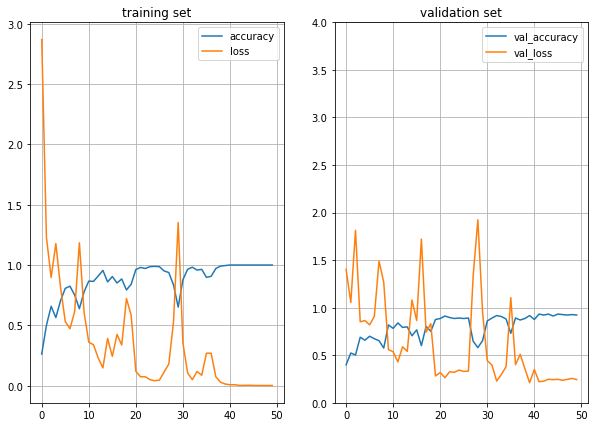

In [46]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.title("training set")
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.title("validation set")
plt.grid()
plt.ylim((0,4))

In [47]:
score = vggmodel.evaluate(dx_test,y_test)
print("accuracy: ", score[1])

6/6 [==============================] - 148s 24s/step - loss: 0.2440 - accuracy: 0.9379
accuracy:  0.9378882050514221


In [48]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y_test,axis=1)
best_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

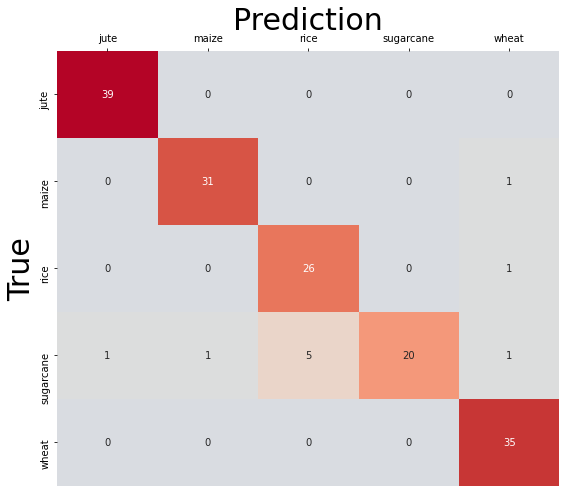

In [49]:
# confusion matrix
plt.figure(figsize = (9,8))
class_label = ['jute','maize','rice','sugarcane','wheat']
fig = sns.heatmap(confusion_matrix(true,prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label)
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

In [79]:
def deeppipline(imagepath, model=vggmodel,label=[-1]):
    pdict={0:'jute',1:'maize',2:'rice',3:'sugarcane',4:'wheat'}

    # predict the image
    pred_x=deep_pipeline([imagepath])
    prediction=model.predict(pred_x)
    pred=np.argmax(prediction[0])
    plt.imshow(plt.imread(imagepath))
    if (label[0]!=-1):
        plt.title('prediction : {0}% {1:.2f} \ntrue : {2}'.format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

In [93]:
# (936, 1300, 3) to (224,224,3)
# read the image
img = plt.imread('W:\\Home\\hahmad\\public\\temp _project\\crop classification\\archive\\jutee.jpg')
# select only (224,224,3)
img = img[:224,:224,:]
print(img.shape)
# save the image
plt.imsave('W:\\Home\\hahmad\\public\\temp _project\\crop classification\\archive\\some_more_images\\some_more_images\\jute\\jute1.jpg',img)

(224, 224, 3)


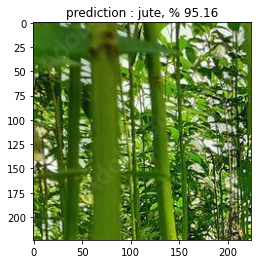

In [94]:
deeppipline('W:\\Home\\hahmad\\public\\temp _project\\crop classification\\archive\\some_more_images\\some_more_images\\jute\\jute1.jpg')

In [8]:
path="W:/Home/hahmad/public/temp _project/satellite images/data"
data_dir=pathlib.Path(path)
print(data_dir)

W:\Home\hahmad\public\temp _project\satellite images\data


In [10]:
class_names= np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['cloudy' 'desert' 'green_area' 'water']


In [12]:
cloudypath=os.path.join(path,'cloudy')
print(cloudypath)
desertpath=os.path.join(path,'desert')
print(desertpath)
green_area=os.path.join(path,'green_area')
print(green_area)
waterpath=os.path.join(path,'water')
print(waterpath)

W:/Home/hahmad/public/temp _project/satellite images/data\cloudy
W:/Home/hahmad/public/temp _project/satellite images/data\desert
W:/Home/hahmad/public/temp _project/satellite images/data\green_area
W:/Home/hahmad/public/temp _project/satellite images/data\water


In [13]:
imagecount=len(list(data_dir.glob("*/*.jpg")))
print(imagecount)

5631


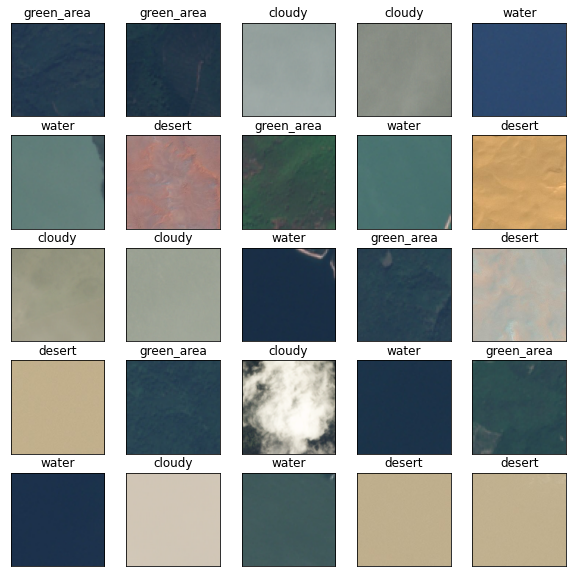

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    random_class=random.choice(class_names)
    img=random.choice(list(data_dir.glob(random_class+"/*.jpg")))
    plt.imshow(plt.imread(img))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)

In [24]:
# print image shape of one image
img = plt.imread(random.choice(list(data_dir.glob("*/*.jpg"))))
print(img.shape)

(256, 256, 4)


In [28]:
train_data=image_dataset_from_directory(path,batch_size=32,image_size=(224,224),validation_split=0.2,subset='training',seed=1337)
valid_data=image_dataset_from_directory(path,batch_size=32,image_size=(224,224),validation_split=0.2,subset='validation',seed=1337)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [33]:
# define the model
model = keras.Sequential([
    keras.layers.Rescaling(1./255,input_shape=(224,224,3)),
    keras.layers.Conv2D(32,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),

    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
])
# show the model in 
model.summary()
# show model in a graph
keras.utils.plot_model(model,to_file='C:\\Users\\hahmad\\Downloads\\model.png',show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)      

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
